## Spreadsheet Authorization

In [1]:
pip install gspread pandas google-auth

In [2]:
import pandas as pd
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
SPREADSHEET_URL = 'https://docs.google.com/spreadsheets/d/1QVyn7oXIa3IY6EjY8kjSc-L58J7FfXiOqU6vcrFklxo/edit?usp=sharing'
CREDENTIALS_FILE = '/content/service-account.json'
WORKSHEET_NAME = 'Form Responses 1'

In [4]:
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name(CREDENTIALS_FILE, scope)
client = gspread.authorize(creds)

In [5]:
spreadsheet_id = "1QVyn7oXIa3IY6EjY8kjSc-L58J7FfXiOqU6vcrFklxo"
spreadsheet = client.open_by_key(spreadsheet_id)
form_sheet = spreadsheet.worksheet("Form Responses 1")

In [6]:
data = form_sheet.get_all_records()
df = pd.DataFrame(data)
df_unique = df.drop_duplicates()

In [7]:
try:
    responses_sheet = spreadsheet.worksheet("Responses")
    responses_sheet.clear()
except gspread.exceptions.WorksheetNotFound:
    responses_sheet = spreadsheet.add_worksheet(title="Responses", rows="1000", cols="20")

In [8]:
set_with_dataframe(responses_sheet, df_unique)

## Dividing events into 4 categories for 4 analytics:


1.   Level Completion Time
2.   Flashlight Switchoffs
3.   Average time per letter collected
4.   Letter Collection Accuracy





In [9]:
worksheet = spreadsheet.worksheet("Responses")

data = worksheet.get_all_records()
df = pd.DataFrame(data)

In [10]:
level_completed_df = df[df['Event Name'].str.contains('Level [12] Completed', na=False)]
torch_df = df[df['Event Name'] == 'TorchSwitchOffs']
time_per_letter_df = df[df['Event Name'] == 'Time-per-letter']
accuracy_df = df[df['Event Name'] == 'LetterAccuracy']

In [11]:
level_completed_df.head(5)

,Timestamp,Event Name,Event Data
0,7/28/2025 22:33:10,Level 1 Completed,74
1,7/29/2025 16:34:24,Level 1 Completed,69
2,7/29/2025 16:35:44,Level 2 Completed,149
3,7/29/2025 16:49:00,Level 1 Completed,53
4,7/29/2025 17:56:53,Level 1 Completed,27


In [12]:
torch_df.head(5)

,Timestamp,Event Name,Event Data
28,8/5/2025 15:22:11,TorchSwitchOffs,"Level 1 - Failed,0"
29,8/5/2025 15:58:31,TorchSwitchOffs,"Level 0 - Failed,0"
30,8/5/2025 17:35:38,TorchSwitchOffs,"Level 2 - Failed,0"
31,8/5/2025 17:35:39,TorchSwitchOffs,"Level 2 - Failed,0"
32,8/5/2025 17:35:40,TorchSwitchOffs,"Level 2 - Failed,0"


In [13]:
time_per_letter_df.head(5)

,Timestamp,Event Name,Event Data
92,8/5/2025 21:00:55,Time-per-letter,-1196
98,8/6/2025 13:55:20,Time-per-letter,-364
102,8/6/2025 14:29:05,Time-per-letter,-454
119,8/6/2025 14:51:51,Time-per-letter,-554
135,8/6/2025 15:11:50,Time-per-letter,-554


In [14]:
accuracy_df.head(5)

,Timestamp,Event Name,Event Data
95,8/6/2025 13:38:26,LetterAccuracy,"Level 1 - Failed,3,0,3,100.00"
96,8/6/2025 13:45:27,LetterAccuracy,"Level 1 - Failed,4,0,4,100.00"
97,8/6/2025 13:52:22,LetterAccuracy,"Level 1,4,0,4,100.00"
100,8/6/2025 13:55:24,LetterAccuracy,"Level 1,5,0,5,100.00"
103,8/6/2025 14:29:11,LetterAccuracy,"Level 1,5,0,5,100.00"


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

## Level Completion Time

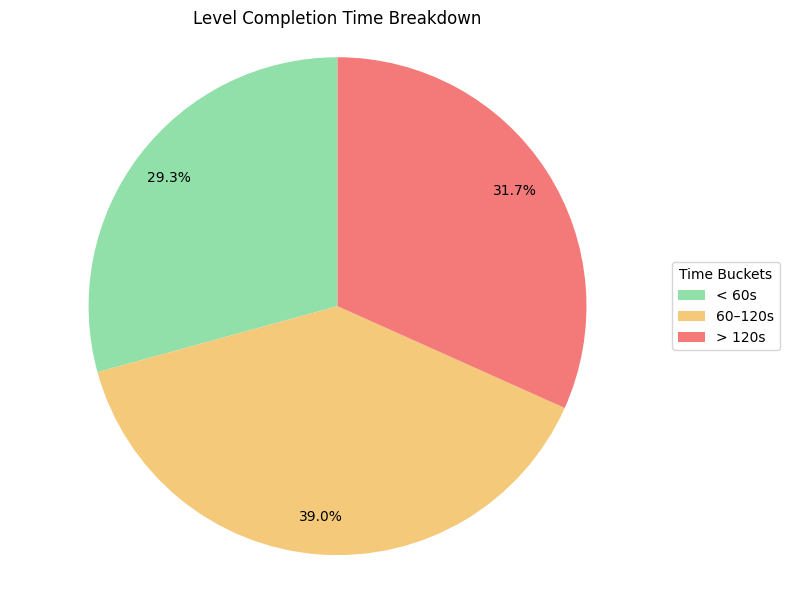

In [16]:
df["Elapsed Time"] = pd.to_numeric(df["Event Data"], errors='coerce')
df = df.dropna(subset=["Elapsed Time"])

def categorize(t):
    if t < 60:
        return "< 60s"
    elif t <= 120:
        return "60–120s"
    else:
        return "> 120s"

df["Bucket"] = df["Elapsed Time"].apply(categorize)
bucket_counts = df["Bucket"].value_counts().reindex(["< 60s", "60–120s", "> 120s"]).fillna(0)

colors = ["#91e0a9", "#f4c97a", "#f47a7a"]

plt.figure(figsize=(8, 6))

# Create the pie chart
patches, texts, autotexts = plt.pie(
    bucket_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85
)

plt.title("Level Completion Time Breakdown")
plt.axis("equal")

# Add a separate legend
plt.legend(
    patches,
    bucket_counts.index,
    title="Time Buckets",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()

## Average time per letter collected

In [17]:
time_per_letter_df['Raw'] = pd.to_numeric(time_per_letter_df['Event Data'], errors='coerce').dropna().astype(int)

time_per_letter_df['Total Time'] = (time_per_letter_df['Raw'] // 10).abs()
time_per_letter_df['Letter Count'] = time_per_letter_df['Raw'] % 10

valid_mask = time_per_letter_df['Letter Count'] != 0
time_per_letter_df.loc[valid_mask, 'Average Time'] = (
    time_per_letter_df.loc[valid_mask, 'Total Time'] / time_per_letter_df.loc[valid_mask, 'Letter Count']
)
time_per_letter_df.drop(columns=['Event Data', 'Raw'], inplace=True)

In [18]:
time_per_letter_df.head(5)

,Timestamp,Event Name,Total Time,Letter Count,Average Time
92,8/5/2025 21:00:55,Time-per-letter,120,4,30.000000
98,8/6/2025 13:55:20,Time-per-letter,37,6,6.166667
102,8/6/2025 14:29:05,Time-per-letter,46,6,7.666667
119,8/6/2025 14:51:51,Time-per-letter,56,6,9.333333
135,8/6/2025 15:11:50,Time-per-letter,56,6,9.333333


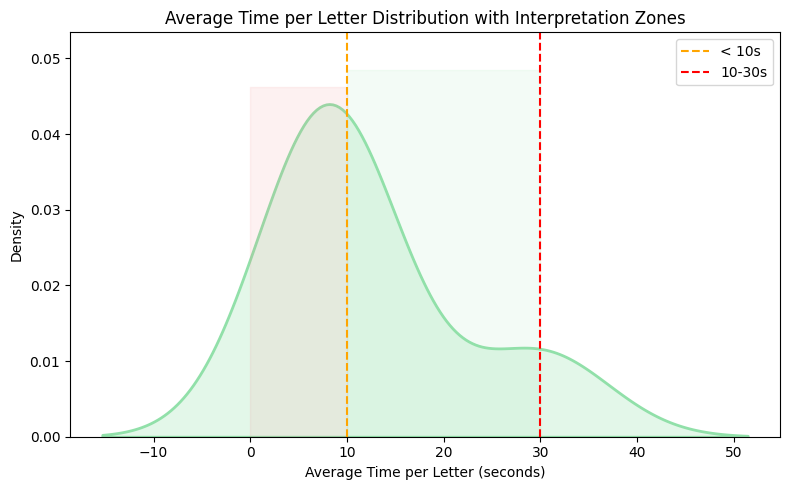

In [19]:
avg_times = time_per_letter_df['Average Time'].dropna()

plt.figure(figsize=(8, 5))

sns.kdeplot(avg_times, fill=True, color="#91e0a9", linewidth=2)

plt.axvline(10, color='orange', linestyle='--', label='< 10s')
plt.axvline(30, color='red', linestyle='--', label='10-30s')

plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]], x1=0, x2=10, color='#f47a7a', alpha=0.1)
plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]], x1=10, x2=30, color='#91e0a9', alpha=0.1)
plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]], x1=30, x2=avg_times.max(), color='#f4c97a', alpha=0.1)

plt.title("Average Time per Letter Distribution with Interpretation Zones")
plt.xlabel("Average Time per Letter (seconds)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## Letter Accuracy Distribution

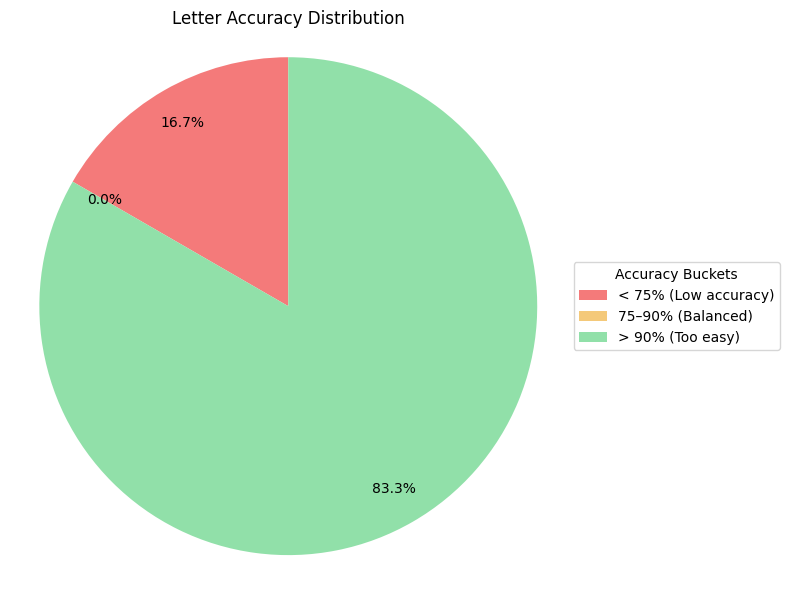

In [24]:
accuracy_df['Total Letters'] = accuracy_df['Event Data'].apply(lambda x: int(x.split(',')[3]))
accuracy_df_filtered = accuracy_df[accuracy_df['Total Letters'] != 0].copy()

accuracy_df_filtered['Accuracy %'] = accuracy_df_filtered['Event Data'].apply(lambda x: float(x.split(',')[-1]))

def categorize_accuracy(p):
    if p < 75:
        return "< 75% (Low accuracy)"
    elif 75 <= p <= 90:
        return "75–90% (Balanced)"
    else:
        return "> 90% (Too easy)"

accuracy_df_filtered['Accuracy Category'] = accuracy_df_filtered['Accuracy %'].apply(categorize_accuracy)

category_counts = accuracy_df_filtered['Accuracy Category'].value_counts().reindex([
    "< 75% (Low accuracy)",
    "75–90% (Balanced)",
    "> 90% (Too easy)"
]).fillna(0)

colors = ['#f47a7a', '#f4c97a', '#91e0a9']

plt.figure(figsize=(8, 6))

patches, texts, autotexts = plt.pie(
    category_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85
)

plt.title("Letter Accuracy Distribution")
plt.axis("equal")

plt.legend(
    patches,
    category_counts.index,
    title="Accuracy Buckets",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()

## Flashlight switchoff count

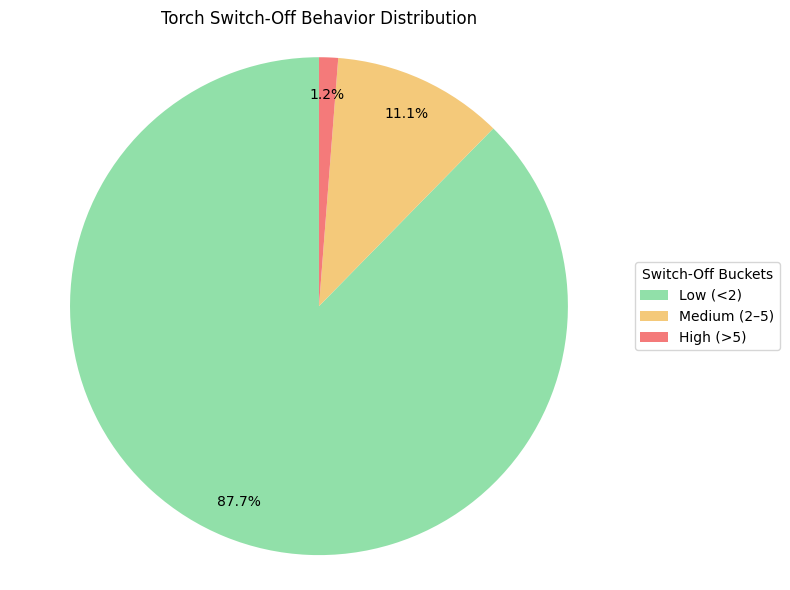

In [23]:
torch_df['SwitchOff Count'] = torch_df['Event Data'].apply(lambda x: int(x.split(',')[-1]))

# Categorize switch-offs
def categorize_switchoffs(count):
    if count > 5:
        return "High (>5)"
    elif 2 <= count <= 5:
        return "Medium (2–5)"
    else:
        return "Low (<2)"

torch_df['Bucket'] = torch_df['SwitchOff Count'].apply(categorize_switchoffs)

# Count per bucket in specific order
bucket_counts = torch_df['Bucket'].value_counts().reindex(["Low (<2)", "Medium (2–5)", "High (>5)"]).fillna(0)

colors = ["#91e0a9", "#f4c97a", "#f47a7a"]

plt.figure(figsize=(8, 6))

patches, texts, autotexts = plt.pie(
    bucket_counts,
    labels=None,           # no slice labels
    autopct='%1.1f%%',    # show % inside slices
    startangle=90,
    colors=colors,
    pctdistance=0.85
)

plt.title("Torch Switch-Off Behavior Distribution")
plt.axis("equal")  # Equal aspect ratio to make the pie circular

# Separate legend outside the pie
plt.legend(
    patches,
    bucket_counts.index,
    title="Switch-Off Buckets",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()